In [ ]:
#Importing packages
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import pandas as pd
import numpy as np
import chromadb
import matplotlib.pyplot as plt
import numpy as np

#Import library code
import helper_code.dataloading as dataloading
import helper_code.model_functions as model_functions
import helper_code.data_vis as data_vis

In [20]:
labels_csv = "camera_data/coronado_hills_binary_11-15-2025.csv"
image_dir = "camera_data/images/"

data = dataloading.get_data(labels_csv=labels_csv, image_dir=image_dir)

In [21]:
train, val, test = dataloading.get_train_val_test(data = data, output_csvs=True)

In [22]:
train['label'].value_counts() / len(train['label'])

label
0    0.518692
1    0.481308
Name: count, dtype: float64

In [33]:
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="q1_train_embeddings")

In [34]:
db_output = collection.get(ids = train['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = train['label']

In [35]:
db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

In [36]:
db_df = db_df.merge(train, left_on = 'ids', right_on='annotation_id')

In [37]:
embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']
img_urls = db_df['img_url']
a_ids = db_df['annotation_id']

In [38]:
reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels)

# reduced_embeddings_4 = reduced_embeddings[:, [1, 3]]

In [39]:
data_vis.save_embeddings_to_json(reduced_embeddings, labels, img_urls, a_ids)

saved embeddings to embedding_data/d3_data.json!


In [40]:
df = pd.DataFrame({
    "x": reduced_embeddings[:,0],
    "y": reduced_embeddings[:,1],
    "label": labels,
    "a_id": val['annotation_id'] 
})

color_map = {0: 'purple', 1: 'gold'}
df['color'] = df['label'].map(color_map)

X = df['x'].values
y = df['label'].values
ids = df['a_id'].values

# find best threshold for desicion stump on x-axis

thresholds = np.unique(X)
best_acc = 0
best_thresh = None
likely_mislabeled = []

for t in thresholds:

    pred1 = (X >= t).astype(int) 
    pred2 = (X < t).astype(int)

    acc1 = (pred1 == y).mean()
    acc2 = (pred2 == y).mean()

    if acc1 > best_acc:
        best_acc = acc1
        best_thresh = t
        likely_mislabeled = ids[pred1 != y]
    if acc2 > best_acc:
        best_acc = acc2
        best_thresh = t
        likley_mislabeled = ids[pred2 != y]

print(f"best threshold: {best_thresh}, accuracy: {best_acc:.3f}")
print("likley mislabeled points:", likley_mislabeled)

best threshold: -9.328647384990363, accuracy: 0.922
likley mislabeled points: [33858. 37030. 40901. ...    nan    nan    nan]


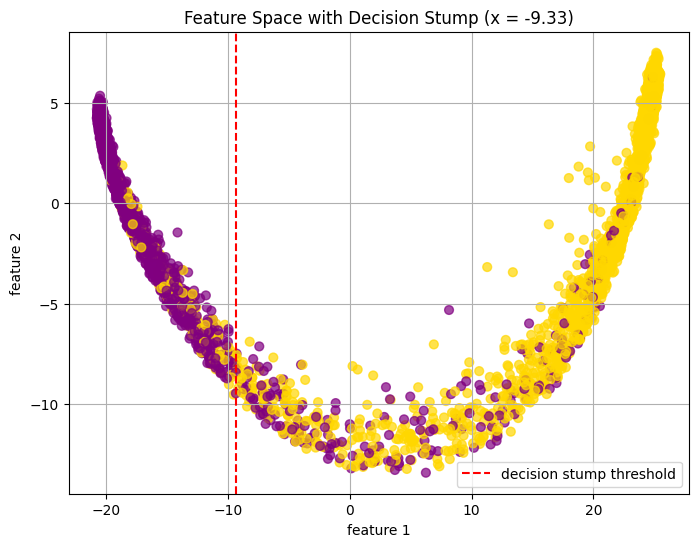

In [42]:
plt.figure(figsize=(8,6))
plt.scatter(df['x'], df['y'], c=df['color'], s=40, alpha=0.7)
plt.axvline(best_thresh, color='red', linestyle='--', label='decision stump threshold')
plt.xlabel("feature 1")
plt.ylabel("feature 2")
plt.title(f"Feature Space with Decision Stump (x = {best_thresh:.2f})")
plt.legend()
plt.grid(True)
plt.show()

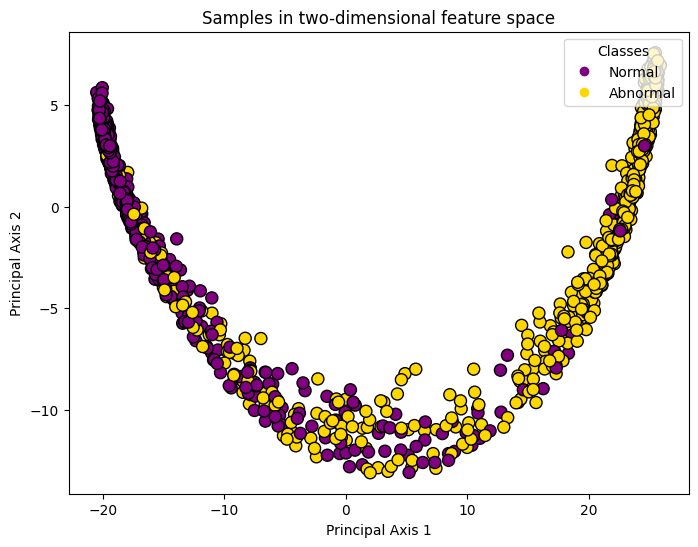

In [16]:
data_vis.plot_data(reduced_embeddings, labels)

Accuracy: 0.8785046728971962


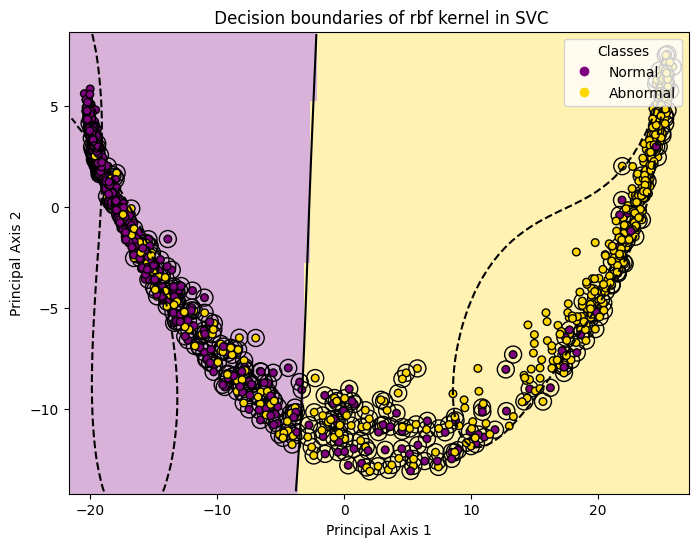

In [18]:
svm_classifier = data_vis.plot_with_decision_boundary("rbf", reduced_embeddings, labels)

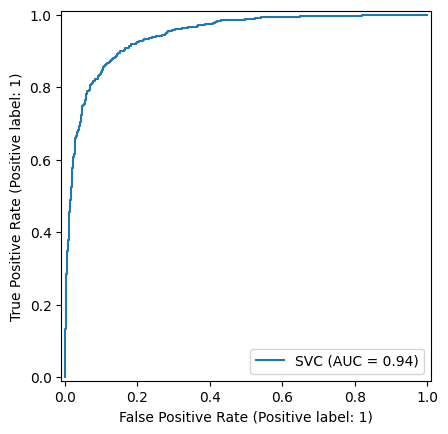

In [19]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

RocCurveDisplay.from_estimator(
   svm_classifier, reduced_embeddings, labels)

plt.show()

In [20]:
from sklearn.decomposition import PCA

# Make sure `embeddings` is a 2D array / DataFrame of shape (n_samples, 768)
X = np.array(embeddings)

pca = PCA(n_components=8, random_state=42)
pcs = pca.fit_transform(X)

pc_cols = [f"PC{i}" for i in range(1, pcs.shape[1] + 1)]
pc_df = pd.DataFrame(pcs, columns=pc_cols)

# Attach label + image info so we can color/stratify plots
pc_df = pd.concat(
    [
        pc_df.reset_index(drop=True),
        db_df[['label', 'img_url', 'annotation_id']].reset_index(drop=True)
    ],
    axis=1
)

pc_df.head()


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:335: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/utils/extmath.py:336: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Library/Frameworks/Python.framework/Versions/3.13/lib/pyth

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,label,img_url,annotation_id
0,-12.290373,-1.619114,-1.256816,0.763355,-0.177277,0.387110,0.681298,-1.348202,1,https://tools.alertcalifornia.org/fireframes5/...,35428
1,7.984132,2.847713,1.219885,-0.520321,-2.491544,2.000223,0.968737,0.211753,0,https://tools.alertcalifornia.org/fireframes5/...,37944
2,-0.479235,1.023606,-4.027884,-2.286274,-2.386424,1.457241,1.219868,-0.285306,1,https://tools.alertcalifornia.org/fireframes5/...,34681
3,14.524074,0.636074,3.463227,1.114666,0.304421,0.932305,-0.852906,-0.933171,0,https://tools.alertcalifornia.org/fireframes5/...,38265
4,-3.840337,-0.537752,-5.972497,1.810519,1.605660,-0.546246,-2.157020,-0.380959,0,https://tools.alertcalifornia.org/fireframes5/...,31930


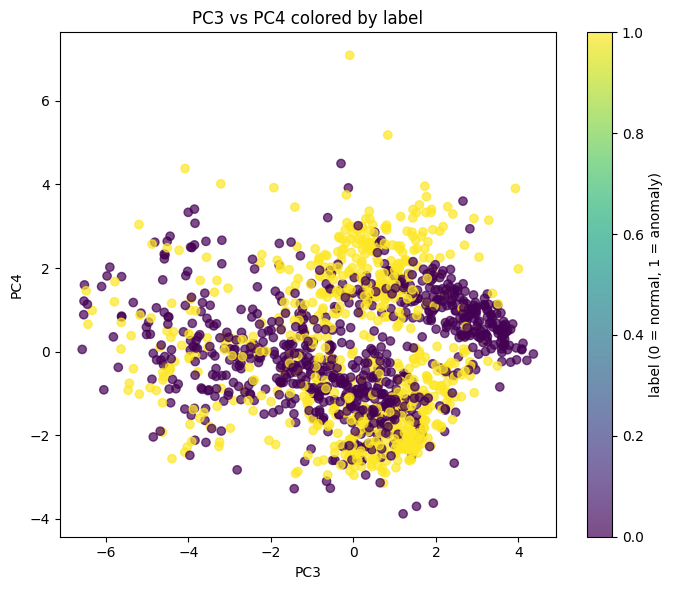

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 6))
scatter = plt.scatter(
    pc_df["PC3"],
    pc_df["PC4"],
    c=pc_df["label"],
    cmap="viridis",
    alpha=0.7
)
plt.colorbar(scatter, label="label (0 = normal, 1 = anomaly)")
plt.xlabel("PC3")
plt.ylabel("PC4")
plt.title("PC3 vs PC4 colored by label")
plt.tight_layout()
plt.show()


Kept 400 images with valid stats out of 400 sampled.
Correlation of PC3/PC4 with brightness / contrast / hue / saturation:

                 PC3       PC4
brightness -0.531351 -0.084428
contrast   -0.484887  0.174276
hue_mean   -0.501998  0.008239
sat_mean   -0.516825  0.085011


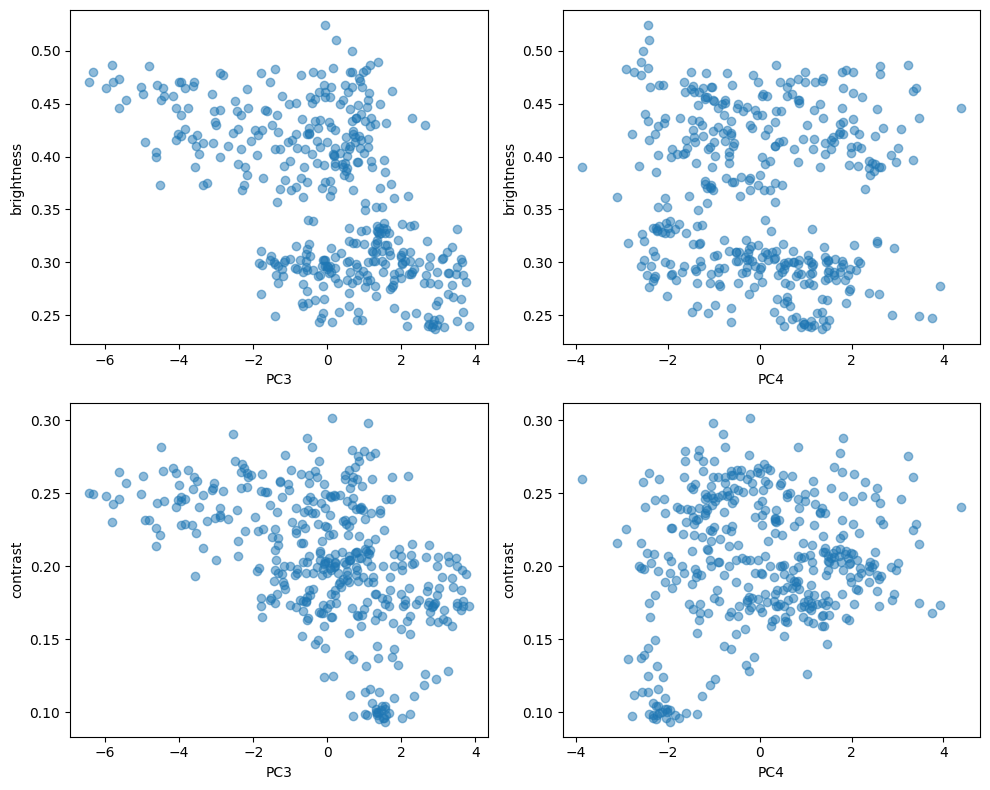

In [37]:
import requests
from io import BytesIO
from PIL import Image
from matplotlib import colors as mpl_colors
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 1. Work on a subset so you don't hammer the server ----
sample_size = min(400, len(pc_df))   # tweak if you want more/less
sampled = pc_df.sample(n=sample_size, random_state=0).copy()

# ---- 2. Function to compute image stats from URL ----
def compute_img_stats_from_url(url: str):
    try:
        # download image
        resp = requests.get(url, timeout=5)
        resp.raise_for_status()

        img = Image.open(BytesIO(resp.content)).convert("RGB")
        arr = np.asarray(img, dtype=np.float32) / 255.0  # (H, W, 3) in [0,1]

        # basic luminance/contrast
        brightness = float(arr.mean())
        contrast = float(arr.std())

        # hue / saturation from HSV
        flat_rgb = arr.reshape(-1, 3)
        flat_hsv = mpl_colors.rgb_to_hsv(flat_rgb)
        hue_mean = float(flat_hsv[:, 0].mean())
        sat_mean = float(flat_hsv[:, 1].mean())

        return pd.Series(
            {
                "brightness": brightness,
                "contrast": contrast,
                "hue_mean": hue_mean,
                "sat_mean": sat_mean,
            }
        )
    except Exception as e:
        # if anything goes wrong, return NaNs so we can filter later
        return pd.Series(
            {
                "brightness": np.nan,
                "contrast": np.nan,
                "hue_mean": np.nan,
                "sat_mean": np.nan,
            }
        )

# ---- 3. Apply to the sample ----
stats = sampled["img_url"].apply(compute_img_stats_from_url)
sampled = pd.concat([sampled.reset_index(drop=True), stats.reset_index(drop=True)], axis=1)

# Drop rows where download failed
sampled = sampled.dropna(subset=["brightness", "contrast", "hue_mean", "sat_mean"])
print(f"Kept {len(sampled)} images with valid stats out of {sample_size} sampled.")

# ---- 4. Correlation of PC3/PC4 with image features ----
cols = ["PC3", "PC4", "brightness", "contrast", "hue_mean", "sat_mean"]
corr = sampled[cols].corr()

print("Correlation of PC3/PC4 with brightness / contrast / hue / saturation:\n")
print(corr.loc[["brightness", "contrast", "hue_mean", "sat_mean"], ["PC3", "PC4"]])

# ---- 5. Optional: quick visualization ----
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].scatter(sampled["PC3"], sampled["brightness"], alpha=0.5)
axes[0, 0].set_xlabel("PC3")
axes[0, 0].set_ylabel("brightness")

axes[0, 1].scatter(sampled["PC4"], sampled["brightness"], alpha=0.5)
axes[0, 1].set_xlabel("PC4")
axes[0, 1].set_ylabel("brightness")

axes[1, 0].scatter(sampled["PC3"], sampled["contrast"], alpha=0.5)
axes[1, 0].set_xlabel("PC3")
axes[1, 0].set_ylabel("contrast")

axes[1, 1].scatter(sampled["PC4"], sampled["contrast"], alpha=0.5)
axes[1, 1].set_xlabel("PC4")
axes[1, 1].set_ylabel("contrast")

plt.tight_layout()
plt.show()


Principal Component 3 appears to encode global image visibility and clarity.
PC3 shows strong negative correlations with brightness (–0.53), contrast (–0.48), color saturation (–0.52), and hue variation (–0.50). This suggests that PC3 increases when images are darker, less colorful, and lower-contrast, consistent with conditions such as fog, haze, nighttime, rain, or other forms of environmental degradation that reduce camera visibility.

Principal Component 4 shows only weak correlations with these image-level statistics, indicating it captures a more subtle structural or geometric feature of the scene rather than a simple illumination or color-based quality.